# 🐈 A/B Testing with Cookie Cats

## 0. Overview

This notebook will be conducting **statistical analysis** and data visualization on A/B test results on the mobile game **Cookie Cats**. Examining player retention rates between the first gate players encounter in the game. This first gate would either be encountered earlier in Level 30, or later in Level 40. 

**🎯 Objective:** 

**Compare 7-day player retention rates between Gate 30 and Gate 40.**
* Is there a statistically significant difference between the two? 
* Which is more effective in showing higher retention rates?

### 0.1 Hypotheses and Metrics

A/B Testing rests on Gate 30 or Gate 40: 

1. Control Group - Gate 30

2. Experimental Group - Gate 40

*(Players were randomly assigned upon installing the mobile game.)*

**Target Metric - Player Retention over 7 days**    
* Gives player data over a defined and considerable length of time (7 days)
* Focusing on **consistent player engagement** rather than short spikes of varying intense activity
* Provides insight into the **long-term** lifespan of the game, as an active returning playerbase would keep the game active as well.

By the end of this notebook, we will conclude whether or not to reject the following hypotheses:

**Hypotheses:**
* **H₀** (null hypothesis) - Gate 30 and gate 40 have the same effectivity of player retention 
* **Hₐ** (alternative hypothesis) - There is significant difference in player retention between Gate 30 and Gate 40

Dataset is sourced from [Kaggle](https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats). 

### 0.2 Importing

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

%matplotlib inline
import seaborn as sns

sns.set_style("darkgrid")
sns.set_theme(
    "notebook",
    rc={"axes.titlesize": 14, "axes.titleweight": "bold", "axes.labelsize": 11},
)

Loading dataset

In [30]:
file_path = "dataset/cookie_cats.csv"
df_import = pd.read_csv(file_path, header=0)
df = df_import.copy()

### 0.3 Dataset Overview

#### Feature Info

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


**Sample Size:** 90,189

"The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

1. **userid**: A unique number that identifies each player.
2. **version**: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
3. **sum_gamerounds**: the number of game rounds played by the player during the first 14 days after install.
4. **retention_1**: Did the player come back and play 1 day after installing?
5. **retention_7**: Did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either (gate)"

#### Dataframe Preview

In [32]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 🧹 1. Data Cleaning

#### 1.1 Check for null or duplicate values

In [33]:
print("Null values in the df: ", df.isna().sum().sum())
print("Duplicate values in the df: ", df.duplicated().sum())

Null values in the df:  0
Duplicate values in the df:  0


There are no null or duplicate values detected

#### 1.2 Check for anomalies in binary features
Are there unique values besides the supposed binary options? (e.g. True / False only)

In [34]:
print(df["retention_1"].unique())
print(df["retention_7"].unique())
print(df["version"].unique())

[False  True]
[False  True]
['gate_30' 'gate_40']


There are no anomalies in binary data values

#### 1.3 Check for 0 values - Completely Inactive Players
Evaluating the *sum_gamerounds* feature for 0 values

In [35]:
print("Number of Inactive Players: ", len(df[df["sum_gamerounds"] == 0]))
print(
    "Percent inactive: ", round(len(df[df.sum_gamerounds == 0]) / len(df), 4) * 100, "%"
)

Number of Inactive Players:  3994
Percent inactive:  4.43 %


🔍 Finding: **4.4%**, almost **~4,000 players who never played** the game or commenced any game rounds.

There are inactive players, but do they have data for the *retention* feature?

Checking for 0 gamerounds but "True" values in retention:

In [36]:
df[
    (df["sum_gamerounds"] == 0) & (df[["retention_1", "retention_7"]].any(axis=1))
].head()

,userid,version,sum_gamerounds,retention_1,retention_7
1000,110479,gate_30,0,False,True
1872,203165,gate_30,0,True,False
2330,257330,gate_30,0,True,False
2803,307703,gate_40,0,True,True
3994,442819,gate_30,0,True,False


Interestingly, there are players with *0 gamerounds* but have *True retention flags.*

This means that they simply **opened the app but still never played** a single round.

Although some return to open the app we **cannot consider them as active or retained players** or for the player retention metric. 

**📝 Final Verdict on Inactive players:** 

We will be **dropping** players with 0 game rounds since they **never engaged** with the game:

In [37]:
df = df[df["sum_gamerounds"] > 0]

In [38]:
print("Number of Inactive Players: ", len(df[df["sum_gamerounds"] == 0]))

Number of Inactive Players:  0


### ⚠️ 1.4 Treating Outliers

For a quick snapshot of the data's outliers and distribution we will look at a box plot:

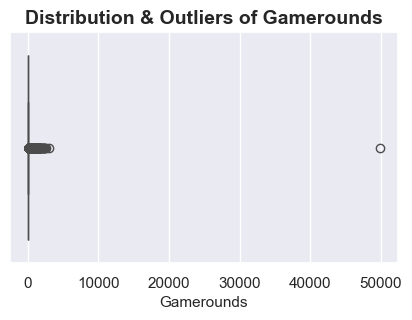

In [39]:
plt.figure(figsize=(5, 3))
sns.boxplot(df, x="sum_gamerounds")

plt.title("Distribution & Outliers of Gamerounds")
plt.xlabel("Gamerounds");

From this plot we can observe that:
- Outliers contribute to a large part of the dataset
- Outliers have a wider range than the bulk of the data
- There is 1 exponential outlier of almost 50,000 rounds 

Listing outliers:

In [40]:
# Calculate Q1 and Q3 for all numerical columns
Q1 = df["sum_gamerounds"].quantile(0.25)
Q3 = df["sum_gamerounds"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[
    (df["sum_gamerounds"] < lower_bound) | (df["sum_gamerounds"] > upper_bound)
]

outlier_values = outliers[["userid", "sum_gamerounds"]]
outlier_values.sort_values(by=["sum_gamerounds"], ascending=False).head(5)

,userid,sum_gamerounds
57702,6390605,49854
7912,871500,2961
29417,3271615,2640
43671,4832608,2438
48188,5346171,2294


The user with the most rounds played has about ~50k rounds, which is exponentially more than the next top 1%-users.

The chances this user was a bot are unknown but likely, considering that this dataset spans only a week's period of retention, and 3k rounds is considered above the 1%.

This data point is to be considered an unknown **anomaly** that deviates from even the other 1% of players and heavily skews the data.

In [41]:
print("Outlier value count: ", len(outlier_values))
percent_outliers = (len(outlier_values) / len(df)) * 100
print(f"Percent of outliers: {percent_outliers:.2f}%")

Outlier value count:  9616
Percent of outliers: 11.16%


- There are 9,616 outlying players who play much more gamerounds than the average casual player. 
- We will **keep these outliers** for our analysis, given that it is a noticeable part **(11.16%)** of the data
- The outliers also showcase the more **invested part of the player base**, important for our consideration of player retention. 
    - As much as possible, we would like to increase player retention for both these top outliers and the average casual player.
- We will however, **disregard the exponential outlier** and consider this data as an **anomaly** to drop.

Dropping the most exceptional outlier with highest amount of gamerounds:

In [42]:
df = df.drop(df["sum_gamerounds"].idxmax())

After data cleaning we are working with a much less expanded view of the data:

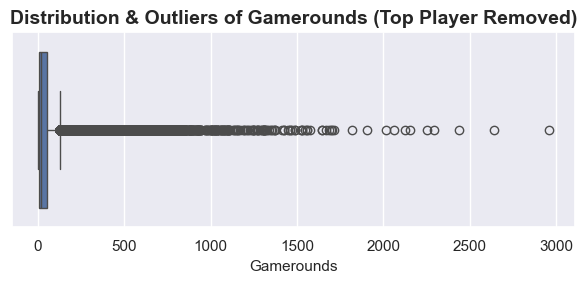

In [43]:
plt.figure(figsize=(6, 3))

sns.boxplot(df, x="sum_gamerounds")
plt.title("Distribution & Outliers of Gamerounds (Top Player Removed)")
plt.xlabel("Gamerounds")
plt.tight_layout()

* The average player stays at a minimal amount of rounds 
* Outliers comprise a large span of data

**📝 Final notes on data cleaning:**
* Our final dataframe considers **active players** who have played at least 1 round *(sum_gamerounds > 0)*
* Considers all **active players minus 1**
    * Removed the highest extreme outlier while still keeping the other top 1% of players

## 2. Analysis

Visual Guide: To guide the reader through visualization in this notebook: in plots, 
* 🟩 Gate 30 will present visually in *darker* green teal  
* 🟨 Gate 40 in *brighter* gold 

### 2.1 Gate 30 vs. Gate 40 - Player Counts, Outliers
#### Player Count per Gate

Is there enough and equal data for both groups?

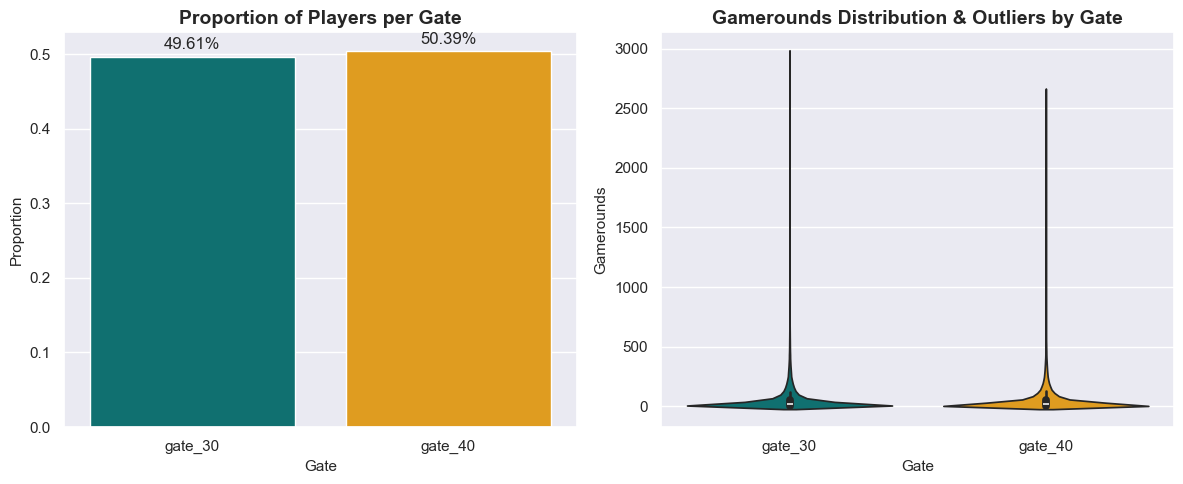

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

order = ["gate_30", "gate_40"]
counts = df["version"].value_counts().reindex(order)
proportions = counts / counts.sum()

ax = sns.barplot(
    x=proportions.index,
    y=proportions.values,
    hue=proportions.index,
    palette=["teal", "orange"],
    ax=axes[0],
)

for i, p in enumerate(proportions.values):
    ax.text(i, p + 0.01, f"{p:.2%}", ha="center")

axes[0].set_title("Proportion of Players per Gate")
axes[0].set_xlabel("Gate")
axes[0].set_ylabel("Proportion")

sns.violinplot(
    df,
    x="version",
    y="sum_gamerounds",
    hue="version",
    palette=["teal", "orange"],
    ax=axes[1],
)
axes[1].set_title("Gamerounds Distribution & Outliers by Gate")
axes[1].set_xlabel("Gate")
axes[1].set_ylabel("Gamerounds")

plt.tight_layout()

**Bar plot:**

* The sample sizes are relatively similar 
* To mathematically check for Sample Ratio Mismatch (SRM), see next section *Chapter 2.1.1*


**Violin plot:**
* Distribution here is also similar
* Only presentable difference is gate 30 has a farther stretch in outliers

We will need to consult further statistical testing *(Chapter 3)* to make a conclusion and further observe for our hypothesis

#### 2.1.1 Sample Ratio Mismatch (SRM) Check

Before we can move forward with testing, we must mathematically check for Sample Ratio Mismatch (SRM) between the two groups.

To do so, for this section, we will be observing another pair of hypotheses:
* **H₀** : The two groups are balanced. There is no sample ratio mismatch detected.
* **Hₐ** : The two groups are not balanced. There is a significant mismatch.


We want to ensure that players assigned to Gate 30 and those for Gate 40 appear equally often

We will be using a stricter significance threshhold (α) that is more commonplace for SRM (SRM is a sensitive value): 
* **α = 0.01**

#### Chi-Square Goodness-of-Fit Testing for SRM

This chi-square test helps observe **if samples follow a specified distribution** - in this case, an **equal** / matching proportion between the two.

It uses the **goodness of fit** statistical model, concerning itself with the **discrepancy between observed values and the values expected** under the model in question. 

Comparing observed vs. expected counts - *expected* being an equal amount / relatively matching proportion between two groups:

In [45]:
observed = df["version"].value_counts().sort_index().values

expected = [observed.sum() / len(observed)] * len(observed)

Conducting the chi-square test:

In [46]:
from scipy.stats import chisquare

chi, p_value = chisquare(f_obs=observed, f_exp=expected)
print("p-value:", p_value)

if p_value <= 0.01:
    print("Conclusion: Warning - SRM may be present.")
else:
    print("Conclusion: SRM not likely.")

p-value: 0.02248293640719808
Conclusion: SRM not likely.


**p 0.02 > α 0.01**

The p-value 0.02 is greater than α 0.01, so it is not below our significance threshold.
* We do not have strong enough evidence to reject the null hypothesis, and there is no strong evidence to suggest SRM.
* The groups appear **balanced** enough and the AB test **passes the SRM check through chi-squared testing**

### 2.2 Distribution

To help make decisions on our route of A/B testing, the distribution of the data must be observed

In [47]:
df.groupby("version")["sum_gamerounds"].describe().T

version,gate_30,gate_40
count,42762.000000,43432.000000
mean,53.667766,53.728357
std,103.743691,105.093012
min,1.000000,1.000000
25%,6.000000,6.000000
50%,18.000000,18.000000
75%,53.000000,55.000000
max,2961.000000,2640.000000


From the descriptive numbers alone, we can see that the data is not normally distributed, with a mean of ~54 but median of 18. Suggesting a right-skewed dataset

#### 99th Percentile and Below

🔍 *Note*: To get a *momentary* closer look at the data, we will be looking at the **99th percentile and below.** 

This is to zoom in to the distribution of the dataset and gather a few points of analysis

In [48]:
p99 = df["sum_gamerounds"].quantile(0.99)

df_99 = df[df["sum_gamerounds"] <= p99]

In [49]:
mean = df_99["sum_gamerounds"].mean()
median = df_99["sum_gamerounds"].median()
mode = df_99["sum_gamerounds"].mode()[0]

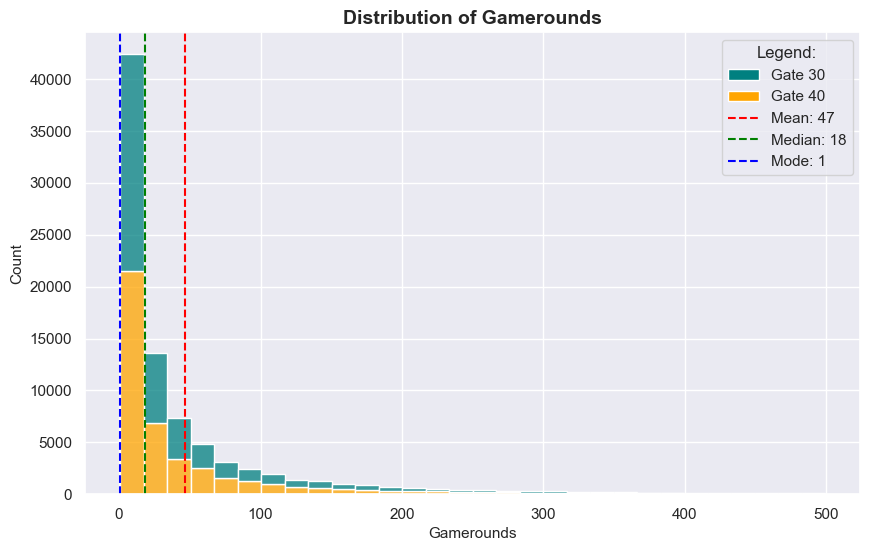

In [50]:
plt.figure(figsize=(10, 6))

sns.histplot(
    df_99,
    x="sum_gamerounds",
    hue="version",
    multiple="stack",
    palette=["teal", "orange"],
    stat="count",
    bins=30,
)

mean_line = plt.axvline(mean, color="red", linestyle="--")
median_line = plt.axvline(median, color="green", linestyle="--")
mode_line = plt.axvline(mode, color="blue", linestyle="--")

label_icons = [
    Patch(facecolor="teal"),
    Patch(facecolor="orange"),
    Line2D([0], [0], color="red", linestyle="--"),
    Line2D([0], [0], color="green", linestyle="--"),
    Line2D([0], [0], color="blue", linestyle="--"),
]

custom_labels = [
    "Gate 30",
    "Gate 40",
    f"Mean: {mean:.0f}",
    f"Median: {median:.0f}",
    f"Mode: {mode:.0f}",
]
plt.legend(handles=label_icons, labels=custom_labels, title="Legend:")

plt.title("Distribution of Gamerounds")
plt.xlabel("Gamerounds");

**Mean, Median, Mode:**
* Mean: The average number of rounds is 47. 
* Median: Middle point of the distribution 18. 50% of players play fewer than 18 rounds, 50% play more than 18.
* Mode: The largest amount of players leave after 1 gameround, characteristic of mobile games where players try out an app.

**Distribution: Exponential**

**Gates:**

It is visually noticeable that **gate 30 has significantly higher counts and presence** than gate 40.

🔍 *Note*: We will be returning to the full dataset for the rest of this notebook, leaving the view of 99th percentile and below

## 3. Statistical Testing

### 3.1 A/B Testing

Observations of our data:
* Independent groups (Gate 30 vs. Gate 40)
* Nominal / binary data (True / False retention)
* Not reliant on distribution assumptions of data

This leads us to a non-parametric approach of testing - the Chi-Square Test of Independence.

#### Chi-Square Test of Independence

This chi-square test makes use of contingency tables to analyze whether proportions differ between groups. 

We will be making use of a standard significance level:

**α = 0.05**

##### * *Test on 1-Day Retention*

We are not expecting to see any changes when it comes to single day retention, but we can quickly compute it here:

In [51]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df["version"], df["retention_1"])
res_1 = chi2_contingency(contingency_table.values)
print("P-value :", res_1.pvalue)

P-value : 0.11554308221600512


p 0.12 > α 0.05

We cannot reject our null hypothesis when looking at single day retention - there is no difference between the gates in this regard.

However we will disregard this test since single day retention is too short to be robust or stable in any way for our testing.

##### Test on 7-Day Retention

Contingency table of values to be used for the Chi-Square Test:

In [52]:
contingency_table = pd.crosstab(df["version"], df["retention_7"])

Retention Rates:

In [53]:
retention_rates = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
print("Retention Rates (%): \n", retention_rates)

Retention Rates (%): 
 retention_7      False      True 
version                          
gate_30      80.157617  19.842383
gate_40      80.967950  19.032050


Raw percentage shows a very minimal (~0.8%) difference in retention 

Conducting the Chi-Square Test:

In [54]:
res_7 = chi2_contingency(contingency_table.values)
print("P-value :", round(res_7.pvalue, 4))

P-value : 0.0027


Our **p-value of 0.027 < α of 0.05.**

The result is **significant to reject our null hypothesis** - suggesting that there is a difference in retention between the 2 gates.

#### 95% Confidence Intervals

In [55]:
from statsmodels.stats.proportion import proportion_confint

ci = contingency_table.apply(
    lambda row: proportion_confint(
        count=row[True], nobs=row.sum(), alpha=0.05, method="wilson"
    ),
    axis=1,
)

retention_rates["ci_lower (%)"] = [x[0] * 100 for x in ci]
retention_rates["ci_upper (%)"] = [x[1] * 100 for x in ci]

retention_rates

retention_7,False,True,ci_lower (%),ci_upper (%)
version,,,,
gate_30,80.157617,19.842383,19.467103,20.223082
gate_40,80.967950,19.032050,18.665611,19.403966


The 95% Confidence Intervals are relatively **narrow**, with **upper and lower bounds no farther than 1% off** the rate, indicating confidence in a precise estimation and a small amount of uncertainty around the retention rate. 

### 3.3 📊 Visualization of A/B Test

From the calculations above - Retention Rates, p-value, and confidence intervals - we can visualize our final results

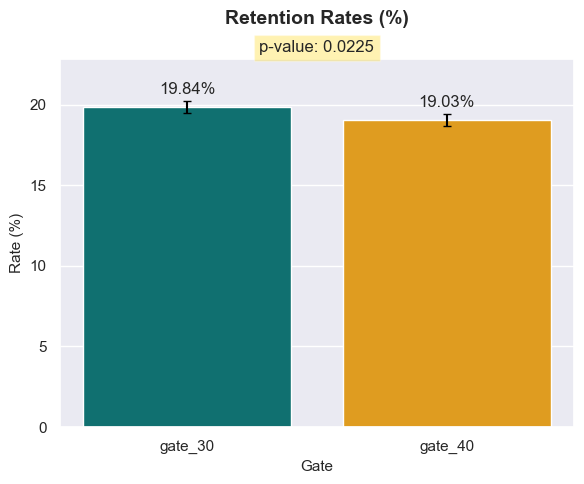

In [56]:
plot_df = retention_rates[True].reset_index()
plot_df.columns = ["Gate", "Retention_7"]

plt.figure(figsize=(6, 5))
ax = sns.barplot(
    plot_df, x="Gate", y="Retention_7", hue="Gate", palette=["teal", "orange"]
)

yerr = np.array(
    [
        plot_df["Retention_7"] - retention_rates["ci_lower (%)"].values,
        retention_rates["ci_upper (%)"].values - plot_df["Retention_7"],
    ]
)

plt.errorbar(
    x=np.arange(len(plot_df)),
    y=plot_df["Retention_7"],
    yerr=yerr,
    fmt="none",
    ecolor="black",
    capsize=3,
)

for i, rate in enumerate(plot_df["Retention_7"]):
    plt.text(i, rate + 0.8, f"{rate:.2f}%", ha="center")

plt.title("Retention Rates (%)", pad=25)

plt.text(
    0.5,
    1.01,
    s=f"p-value: {p_value:.4f}",
    ha="center",
    va="bottom",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="gold", alpha=0.3),
)

plt.ylabel("Rate (%)")
plt.ylim(0, max(plot_df["Retention_7"]) + 3)
plt.tight_layout()

The actual percentage difference in retention rates is small (~0.8% difference), but the chi-square test confirms that it is statistically significant enough to state that Gate 30 has a higher retention rate.

## 4. Conclusion
**Data**:
* Distribution of data is exponential and skewed
* Target metric is binary (True/False) for Retention over 7 days
* Comparing two independent groups
* The above leads us to choosing the chi-squared test of independence, with the following results:
    * p-value of 0.02 is below our threshold of 0.05


**Retention Rates** and our **A/B testing results**:
* We reject our null hypothesis that the gates have the same player retention. 
* **Estimated treatment effect** is *0.81* percent higher retention, 
* Which is a **statistically significant** higher rate according to our Chi-squared test

**Final Recommendations:**
* Earlier gate provides a better experience for players
* Players gravitate to the earlier checkpoint as a faster incentive
* It is **recommended that the Cookie Cats team keep the first gate in the game as Gate 30** 